<a href="https://colab.research.google.com/github/VaneezaAhmad/Text-Prediction/blob/main/Urdu_predictive_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

There is a ton of Language modeling and Natural Language Processing work done in English and other popular languages. This project is generating the predictions of words in Urdu which is the national language of Pakistan and the is popular in South East Asia. This prediction model can be used in many ways such for creating a virtual assistant, for a search engines or keyboard predictive text or for chatbots. This can make typing easier and faster for Urdu keyboard users.

# Data Collection

Data was collected from https://www.kaggle.com/disisbig/urdu-wikipedia-articles. The author of the dataset had over 100,000 wikipedia articles in urdu. For this project only 1000 of those articles were used. 

# Import in relevant libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [1]:
# from data import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import spacy
import tensorflow as tf
from nltk.probability import FreqDist

from sklearn.model_selection import GridSearchCV
import pickle

from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.optimizers import RMSprop

In [2]:
! pip install python-bidi

In [3]:
pip install arabic-reshaper

In [4]:
from bidi.algorithm import get_display
import arabic_reshaper

# Read in data

Data.py file has code to combine text files together in one file named urdu_data.txt


In [5]:
from google.colab import files
uploaded = files.upload()


Saving data.txt to data.txt


In [ ]:
# merge_per_folder("urdu-data", "data.txt")

In [6]:
urdu =  open("data.txt", "r", encoding="utf_8").read()

In [7]:
len(urdu)

147585

In [8]:
! pip install ar_wordcloud

     |████████████████████████████████| 366 kB 3.9 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0


downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


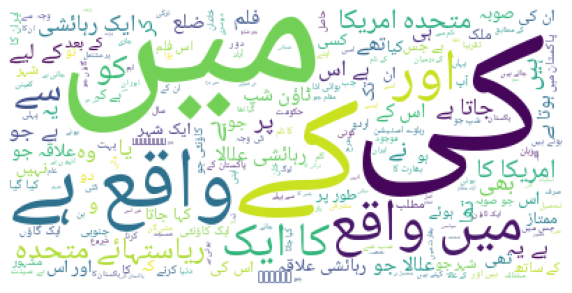

In [9]:
from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")

wc = awc.from_text(urdu)

plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show();

# Preprocessing

## Spacy

In [10]:
nlp = spacy.blank("ur")

In [11]:
doc = nlp(urdu)

In [12]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

Removal of special and unnecessary characters

In [13]:
urdu_words = [token.text for token in doc if token.text not in "′″،۔؟،ء\n-\n\n-.\n ./;:°،ء'"]


In [14]:
urdu_words = [token for token in urdu_words if token not in "،‘‘..{.,′″،/،ء'،./°،ء'.-""'-.[\‘‘؎،)‘"]


In [42]:
urdu_words = [token for token in urdu_words if token not in "·èøēŁłąśóżóțŁ'ù'ó'à'Î'é"]

In [43]:
urdu_words = [token for token in urdu_words if token not in "،،\n \n،,\n,,\n\n,,,\n\n\n,,,,\n\n\n\n\t\t\t\t\t\t\t\t\n"]

In [44]:
urdu_words = [token for token in urdu_words if token not in ")‘‘کوما': 2؛)‘‘کوما)‘‘شونین)‘‘شونین': 1"]

In [46]:
urdu_words = [token for token in urdu_words if token not in string.punctuation]

In [45]:
urdu_words = [word.translate(str.maketrans('', '', '\u200b–’—“►\u200f′″\u200b\u200b◀\u200c')) \
                  for word in urdu_words]
      #             '\u200b', '\u200b\u200b', '\u200f', '–', '—', '’', '“', '′″', '►',
      #  '◀', 'ﷲ', 'ﷺ', 'ﷺنے'], dtype='<U24')

Removal of numbers and english words and letters 

In [52]:
urdu_words = [word.translate(str.maketrans('', '', '۱۲۳۴۵،۶۷۸۹۰٫')) \
                  for word in urdu_words]

In [21]:
urdu_words = [word.translate(str.maketrans('', '', '..."0123456789!+-')) \
                  for word in urdu_words]

In [22]:
urdu_words = [word.translate(str.maketrans('', '', 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')) \
                  for word in urdu_words]

In [50]:
urdu_words=[word for word in urdu_words if word != '']

In [53]:
len(urdu_words)

29088

Word cloud

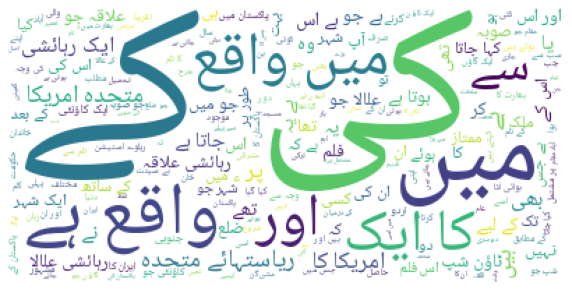

In [54]:
# from ar_wordcloud import ArabicWordCloud
awc = ArabicWordCloud(background_color="white")

unique_string=(" ").join(urdu_words)
wc = awc.from_text(unique_string)

plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show();

In [26]:
word_frequencies = {}
for word in doc:
    if word.text in urdu_words:
            if word.text not in word_frequencies.keys():
                word_frequencies[word.text] = 1
            else:
                word_frequencies[word.text] += 1

In [27]:
sorted(word_frequencies.items(), key=lambda x: x[1], reverse=True)[:20]

[('ہے', 1269),
 ('میں', 1237),
 ('کے', 943),
 ('کا', 806),
 ('ایک', 774),
 ('کی', 708),
 ('اور', 562),
 ('جو', 522),
 ('سے', 515),
 ('واقع', 478),
 ('اس', 365),
 ('ہیں', 277),
 ('کو', 253),
 ('پر', 210),
 ('یہ', 200),
 ('نے', 179),
 ('یا', 178),
 ('متحدہ', 170),
 ('ریاستہائے', 165),
 ('امریکا', 164)]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1729 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 1746 missing from current font.
  font.set_text(s, 0, flags=flags)


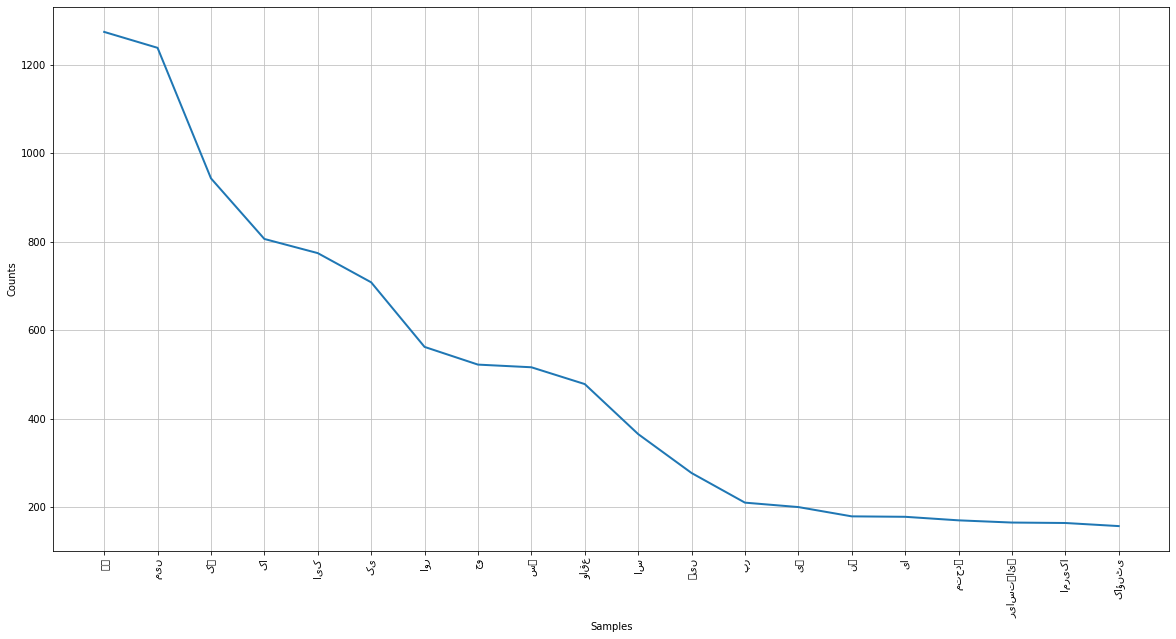

In [28]:
from nltk.probability import FreqDist

fdist = FreqDist(urdu_words)
plt.figure(figsize=(20, 10))
fdist.plot(20);

In [29]:
urdu_words[:10]

['زیورخ',
 'کیلیفورنیا',
 'ریاستہائے',
 'متحدہ',
 'امریکا',
 'کا',
 'ایک',
 'انانکارپوریٹڈ',
 'علاقہ',
 'جو']

Taking the unique words and creating a dictionary containing each word and an index for that word

In [55]:
unique_words = np.unique(urdu_words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [31]:
# unique_word_index

In [56]:
len(unique_word_index)

5765

In [33]:
unique_words[4400:4800]

array(['واٹر', 'واٹلی', 'واپس', 'واپسی', 'واکٹلو', 'واہ', 'وایو', 'وجود',
       'وجودمیں', 'وجوہات', 'وجہ', 'وحشی', 'وحید', 'ور', 'وراثوں',
       'وراثہ', 'وراثی', 'وراثے', 'ورتھ', 'ورجینیا', 'وردی', 'ورق',
       'ورلڈ', 'ورمونٹ', 'ورنن', 'وروں', 'ورک', 'وری', 'ورینچیو', 'ورے',
       'وزارت', 'وزارتِ', 'وزیر', 'وزیراعظم', 'وزیرستان', 'وزیری',
       'وسائل', 'وسار', 'وساطت', 'وسط', 'وسطی', 'وسعت', 'وسلم', 'وسلوئی',
       'وسکونسن', 'وسیتین', 'وسیع', 'وسیک', 'وشور', 'وصول', 'وضاحت',
       'وطن', 'وغیرہ', 'وغیرہ۔', 'وغیرہ۔لسانیات', 'وفا', 'وفات', 'وفاق',
       'وفاقی', 'وقت', 'وقف', 'وقفہ', 'ول', 'ولادت', 'ولتورت', 'ولس',
       'ولسن', 'ولیم', 'ونڈاؤس', 'ونڈسر', 'وو', 'ووسٹر', 'وووکواوک',
       'ووچنگ', 'ووڈ', 'ووڈرف', 'وویوڈیشپ', 'وَالْاَرْضِ', 'وَجَّھْتُ',
       'وَجْھِیَ', 'وَمَا', 'وُہ', 'وٹامن', 'وڈ', 'وڈیو', 'وژن', 'وک',
       'وکالت', 'وکٹوریہ', 'وگر', 'وھام', 'وہ', 'وہاڑی', 'وہاں', 'وہی',
       'وہیتوں', 'وہیں', 'وی', 'ویانا', 'ویب', 'ویبسٹر', 'ویتال',
       'ویتنام'

## Separation of Target and Variables 

Taking the first three words from the list of words and making it the feature and the next word (4th word) as the target.  

In [57]:
WORD_LENGTH = 3
prev_words = []
next_words = []
for i in range(len(urdu_words) - WORD_LENGTH):
    prev_words.append(urdu_words[i:i + WORD_LENGTH])
    next_words.append(urdu_words[i + WORD_LENGTH])
print(prev_words[:5])
print(next_words[:5])

[['زیورخ', 'کیلیفورنیا', 'ریاستہائے'], ['کیلیفورنیا', 'ریاستہائے', 'متحدہ'], ['ریاستہائے', 'متحدہ', 'امریکا'], ['متحدہ', 'امریکا', 'کا'], ['امریکا', 'کا', 'ایک']]
['متحدہ', 'امریکا', 'کا', 'ایک', 'انانکارپوریٹڈ']


Converting the words into 0's and 1's

In [58]:
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
y = np.zeros((len(next_words), len(unique_words)), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    y[i, unique_word_index[next_words[i]]] = 1

In [59]:
len(X), len(y), X.shape, y.shape

(29085, 29085, (29085, 3, 5765), (29085, 5765))

In [56]:
target=pd.DataFrame(next_words)
target.tail(10)

,0
29075,ایک
29076,انانکارپوریٹڈ
29077,علاقہ
29078,جو
29079,انیو
29080,کاؤنٹی
29081,کیلیفورنیا
29082,میں
29083,واقع
29084,ہے


In [57]:
target.value_counts(normalize=True).head(20)

ہے           0.043803
میں          0.042565
کے           0.032422
کا           0.027712
ایک          0.026612
کی           0.024342
اور          0.019323
جو           0.017947
سے           0.017741
واقع         0.016435
اس           0.012549
ہیں          0.009524
پر           0.007220
یہ           0.006876
نے           0.006154
یا           0.006120
متحدہ        0.005845
امریکا       0.005639
ریاستہائے    0.005639
کاؤنٹی       0.005398
dtype: float64

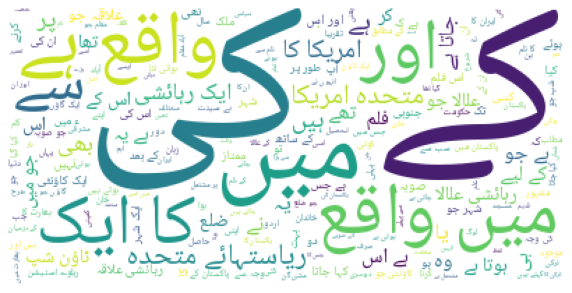

In [60]:
awc = ArabicWordCloud(background_color="white")

unique_string=(" ").join(next_words)
wc = awc.from_text(unique_string)

plt.figure(figsize=(10,6))
plt.imshow(wc)
plt.axis("off")
plt.show();

# Models


In [120]:
scores = []


In [130]:
accuracy=[]
loss=[]

## FSM

Creating a simple model with one lstm layer, one dense layer and a output layer to check the performance of the model.  

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.callbacks import TensorBoard

In [62]:
model = Sequential()
model.add(LSTM(32, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation("softmax"))

optimizer = RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

history=model.fit(X,y, epochs=100, batch_size=64, callbacks=[checkpoint]).history

Epoch 1/100
455/455 [==============================] - 20s 5ms/step - loss: 6.9450 - accuracy: 0.0686 - top_k_categorical_accuracy: 0.1711

Epoch 00001: loss improved from inf to 6.61580, saving model to nextword1.h5
Epoch 2/100
455/455 [==============================] - 2s 5ms/step - loss: 5.8990 - accuracy: 0.1759 - top_k_categorical_accuracy: 0.2425

Epoch 00002: loss improved from 6.61580 to 5.97586, saving model to nextword1.h5
Epoch 3/100
455/455 [==============================] - 3s 6ms/step - loss: 5.8514 - accuracy: 0.2211 - top_k_categorical_accuracy: 0.2805

Epoch 00003: loss did not improve from 5.97586
Epoch 4/100
455/455 [==============================] - 2s 5ms/step - loss: 5.9775 - accuracy: 0.2500 - top_k_categorical_accuracy: 0.3051

Epoch 00004: loss did not improve from 5.97586
Epoch 5/100
455/455 [==============================] - 2s 5ms/step - loss: 5.9787 - accuracy: 0.2786 - top_k_categorical_accuracy: 0.3250

Epoch 00005: loss did not improve from 5.97586
Epoch

In [63]:
# model.save('urdu-modelfsm.h5')
# pickle.dump(history, open("urdu-resultsfsm.p", "wb"))

In [121]:
scores.append(51.2)

In [131]:
accuracy.append(50.07)
loss.append(4.82)

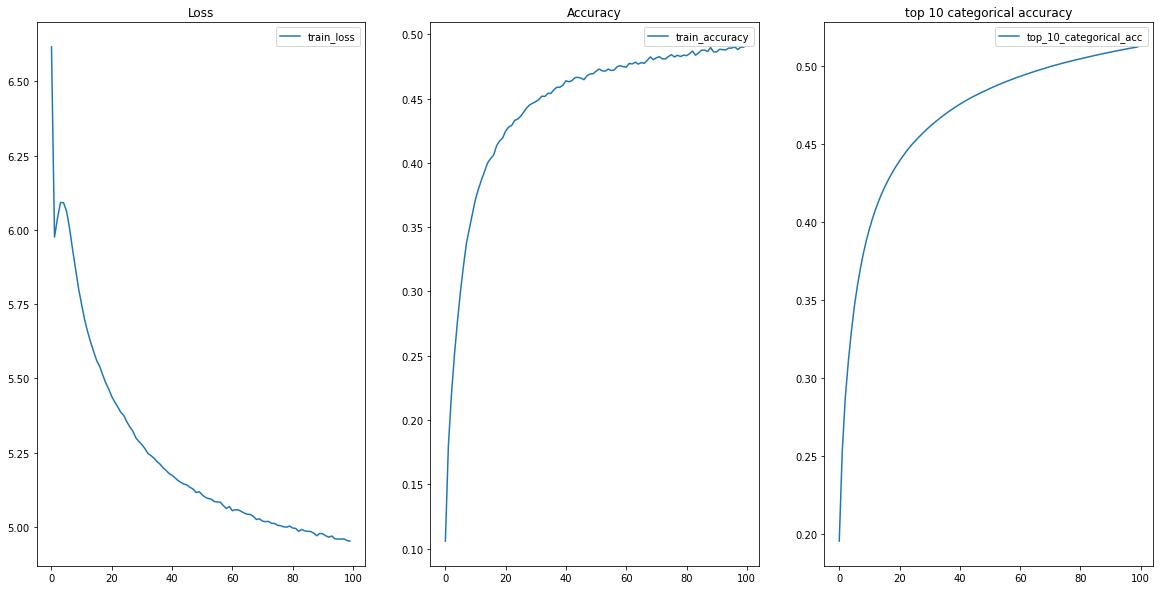

In [64]:
train_loss = history['loss']
train_acc = history['accuracy']
# val_loss =history['val_loss']
# val_acc = history['val_accuracy']
train_top_acc = history["top_k_categorical_accuracy"]
# val_top_acc = history["val_top_k_categorical_accuracy"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

ax1.plot(train_loss, label='train_loss')
# ax1.plot(val_loss, label='validation_loss')
ax1.set_title("Loss")
ax1.legend()

ax2.plot(train_acc, label='train_accuracy')
# ax2.plot(val_acc, label='val_accuracy')
ax2.set_title("Accuracy")
ax2.legend()

ax3.plot(train_top_acc, label='top_10_categorical_acc')
# ax3.plot(val_top_acc, label='validation_top_10_categorical_accuracy')
ax3.set_title("top 10 categorical accuracy")
ax3.legend()

The graphs above shows using the accuracy measure top_k_categoricalAccuracy that the model is doing well in regards to variance and there is a 50% chance that the target is in the top 5 predicted words. 

### graph function to display metric performance

In [75]:
def graph(results):
  train_loss = results['loss']
  train_acc = results['accuracy']
  train_top_acc = results["top_k_categorical_accuracy"]
  # val_loss =results['val_loss']
  # val_acc = results['val_accuracy']
  # val_top_acc = results["val_top_k_categorical_accuracy"]

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

  ax1.plot(train_loss, label='train_loss')
  # ax1.plot(val_loss, label='validation_loss')
  ax1.set_title("Loss")
  ax1.legend()

  ax2.plot(train_acc, label='train_accuracy')
  # ax2.plot(val_acc, label='val_accuracy')
  ax2.set_title("Accuracy")
  ax2.legend()

  ax3.plot(train_top_acc, label='top_5_categorical_acc')
  # ax3.plot(val_top_acc, label='validation_top_5_categorical_accuracy')
  ax3.set_title("Top 5 categorical accuracy")
  ax3.legend()

## Model 1 (2 LSTM layers, learning rate=0.001)

Adding another LSTM layer along with increasing the number of nodes. Adding two dropout layers for regularization. 

In [66]:
model1 = Sequential()
model1.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(128))
model1.add(Dropout(0.3))
model1.add(Dense(y.shape[1], activation='relu'))
model1.add(Activation("softmax"))
print(model1.summary())

optimizer = RMSprop(learning_rate=0.001)

model1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint1 = ModelCheckpoint("nextword2.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 128)            3017728   
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5765)              743685    
_________________________________________________________________
activation_1 (Activation)    (None, 5765)              0         
Total params: 3,892,997
Trainable params: 3,892,997
Non-trainable params: 0
____________________________________________

In [67]:
results1=model1.fit(X,y, epochs=100, batch_size=64, callbacks=[checkpoint1]).history

Epoch 1/100
455/455 [==============================] - 8s 8ms/step - loss: 8.1198 - accuracy: 0.0427 - top_k_categorical_accuracy: 0.1293

Epoch 00001: loss improved from inf to 7.97539, saving model to nextword2.h5
Epoch 2/100
455/455 [==============================] - 4s 8ms/step - loss: 7.8126 - accuracy: 0.0498 - top_k_categorical_accuracy: 0.1540

Epoch 00002: loss improved from 7.97539 to 7.76606, saving model to nextword2.h5
Epoch 3/100
455/455 [==============================] - 4s 8ms/step - loss: 7.6555 - accuracy: 0.0515 - top_k_categorical_accuracy: 0.1633

Epoch 00003: loss improved from 7.76606 to 7.63753, saving model to nextword2.h5
Epoch 4/100
455/455 [==============================] - 4s 8ms/step - loss: 7.5888 - accuracy: 0.0565 - top_k_categorical_accuracy: 0.1702

Epoch 00004: loss improved from 7.63753 to 7.58745, saving model to nextword2.h5
Epoch 5/100
455/455 [==============================] - 4s 8ms/step - loss: 7.5824 - accuracy: 0.0636 - top_k_categorical_acc

In [122]:
scores.append(57.1)

In [132]:
accuracy.append(21.66)
loss.append(6.83)

In [133]:
scores, accuracy, loss

([51.2, 57.1, 68.5, 94.04, 83.3, 89.3], [50.07, 21.66], [4.82, 6.83])

In [ ]:
# model1.save('urdu-model1.h5')
# pickle.dump(results1, open("urdu-results1.p", "wb"))

In [ ]:
# model = load_model('urdu-model1.h5')
# history = pickle.load(open("historygs.p", "rb"))

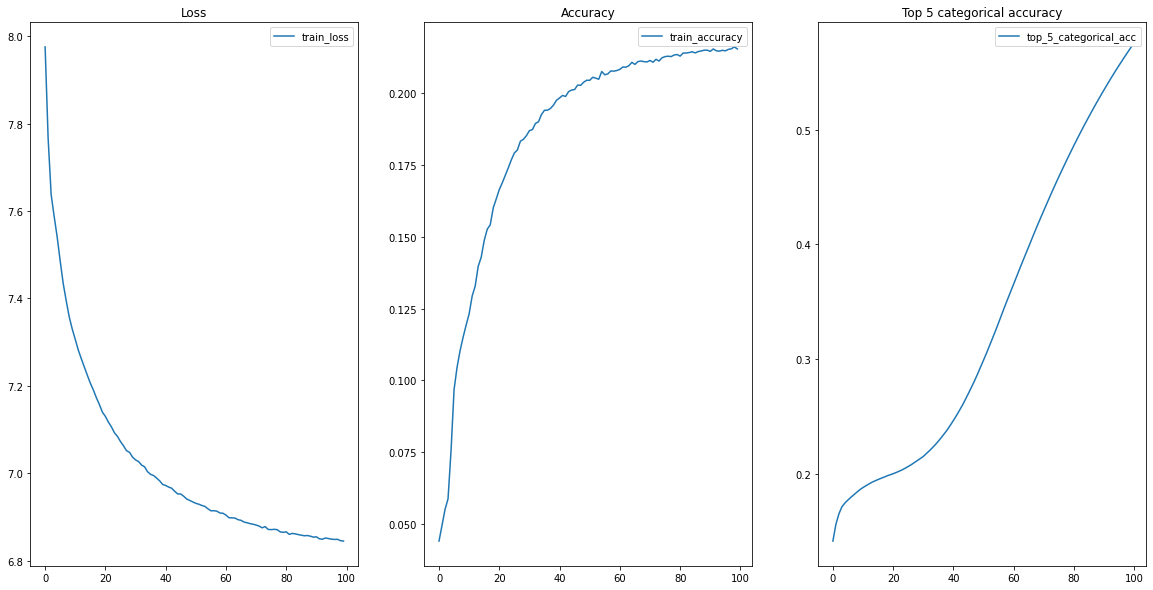

In [76]:
graph(results1)

Looking at top_k_categorical accuracy, this model performed well, with over 60% accuracy and very little variance in the training and validation set. 

## Model 2 (LSTM 256 nodes)

Increasing the number of nodes in the LSTM layers to check how the model will perform. 

In [77]:
model2 = Sequential()
model2.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(256))
model2.add(Dropout(0.3))
model2.add(Dense(y.shape[1], activation='relu'))
model2.add(Activation("softmax"))
print(model2.summary())

optimizer = RMSprop(learning_rate=0.001)

model2.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)

checkpoint2 = ModelCheckpoint("nextword3.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results2=model2.fit(X,y, epochs=100, batch_size=64, callbacks=[checkpoint2]).history

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 256)            6166528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 256)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5765)              1481605   
_________________________________________________________________
activation_2 (Activation)    (None, 5765)              0         
Total params: 8,173,445
Trainable params: 8,173,445
Non-trainable params: 0
____________________________________________

In [123]:
scores.append(68.5)

In [134]:
accuracy.append(27.8)
loss.append(6.27)

In [ ]:
# model2.save('urdu-model2.h5')
# pickle.dump(results2, open("urdu-results2.p", "wb"))

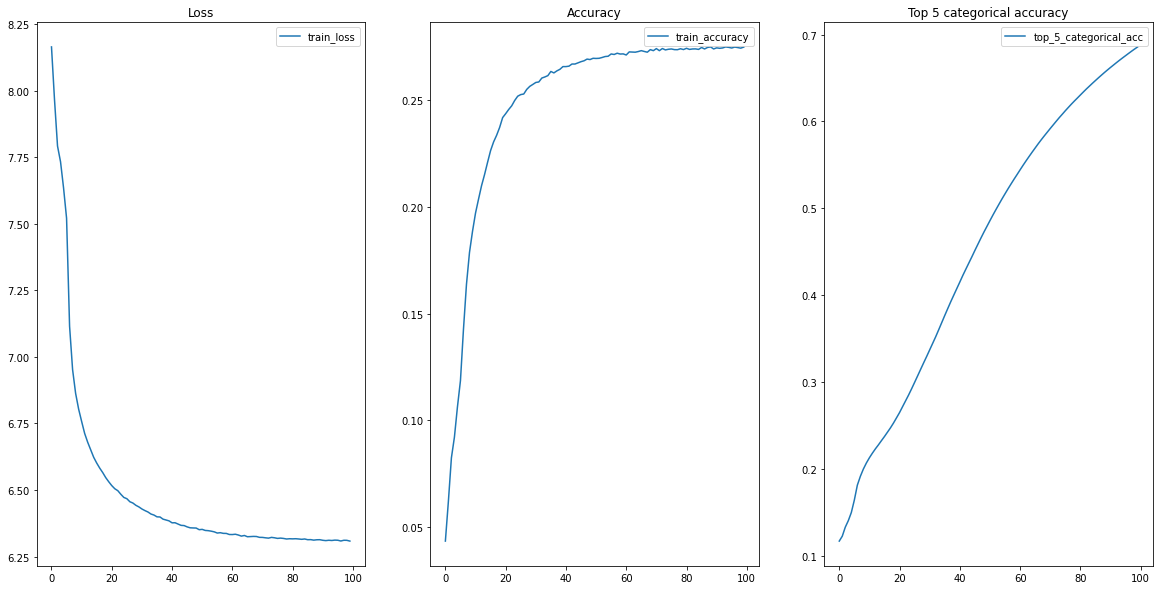

In [78]:
graph(results2)

From the graphs we can see this model is performing a lot better. As our epochs increase, there is over a 90% chance that out target is in the top 5 predicted words. There is very little variance in the validation and train set. 

## Model 5 (Best Model)

Adding more nodes in the LSTM layer and changing the optimizer to adam

In [158]:
model5 = Sequential()
model5.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model5.add(Dropout(0.2))
model5.add(LSTM(512))
model5.add(Dropout(0.3))
model5.add(Dense(y.shape[1], activation='relu'))
model5.add(Dense(y.shape[1], activation="softmax"))
print(model5.summary())

# optimizer = RMSprop(learning_rate=0.001)

model5.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint5 = ModelCheckpoint("nextword5.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results5=model5.fit(X,y, epochs=150, batch_size=64, callbacks=[checkpoint5]).history

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 3, 512)            12857344  
_________________________________________________________________
dropout_18 (Dropout)         (None, 3, 512)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 5765)              2957445   
_________________________________________________________________
dense_13 (Dense)             (None, 5765)              33240990  
Total params: 51,154,979
Trainable params: 51,154,979
Non-trainable params: 0
__________________________________________

In [124]:
scores.append(94.04)

In [135]:
accuracy.append(90.7)
loss.append(0.26)

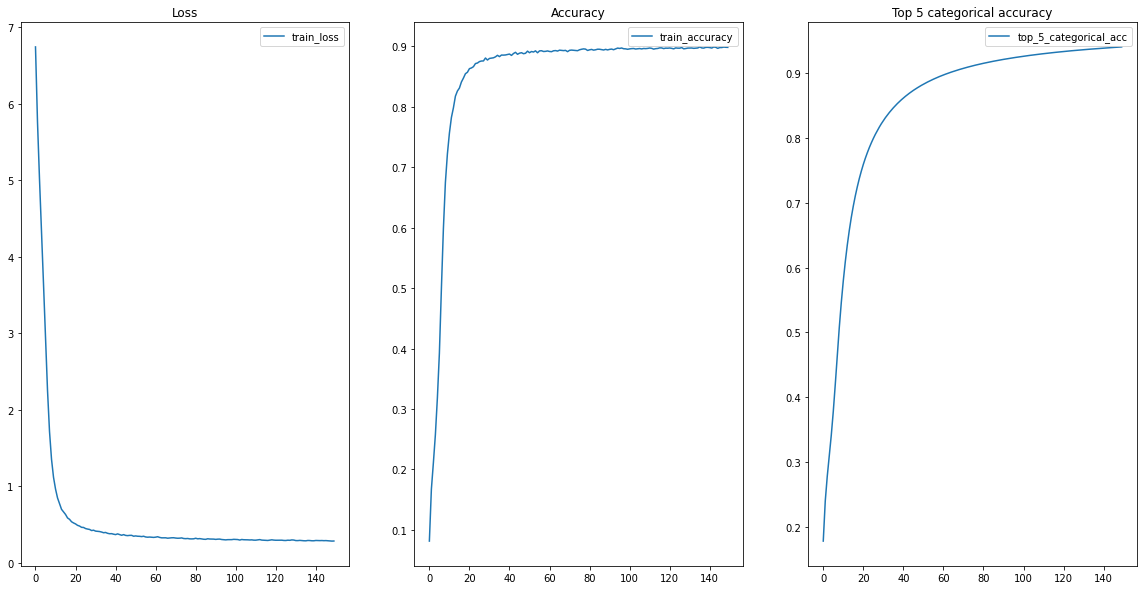

In [87]:
graph(results5)

## Model 6

Adding another LSTM with 256 nodes and Dropout layer

In [88]:
model6 = Sequential()
model6.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(256, return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(256))
model6.add(Dropout(0.2))
model6.add(Dense(y.shape[1], activation='relu'))
model6.add(Dense(y.shape[1],Activation("softmax")))
print(model6.summary())

optimizer = RMSprop(learning_rate=0.001)

model6.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-1,
                           verbose=1,
                           mode='min', patience=5)


checkpoint6 = ModelCheckpoint("nextword6.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

results6=model6.fit(X,y, epochs=150, batch_size=64, callbacks=[checkpoint6]).history

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 3, 256)            6166528   
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 256)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 3, 256)            525312    
_________________________________________________________________
dropout_14 (Dropout)         (None, 3, 256)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 5765)             

In [125]:
scores.append(83.3)

In [136]:
accuracy.append(88.05)
loss.append(0.51)

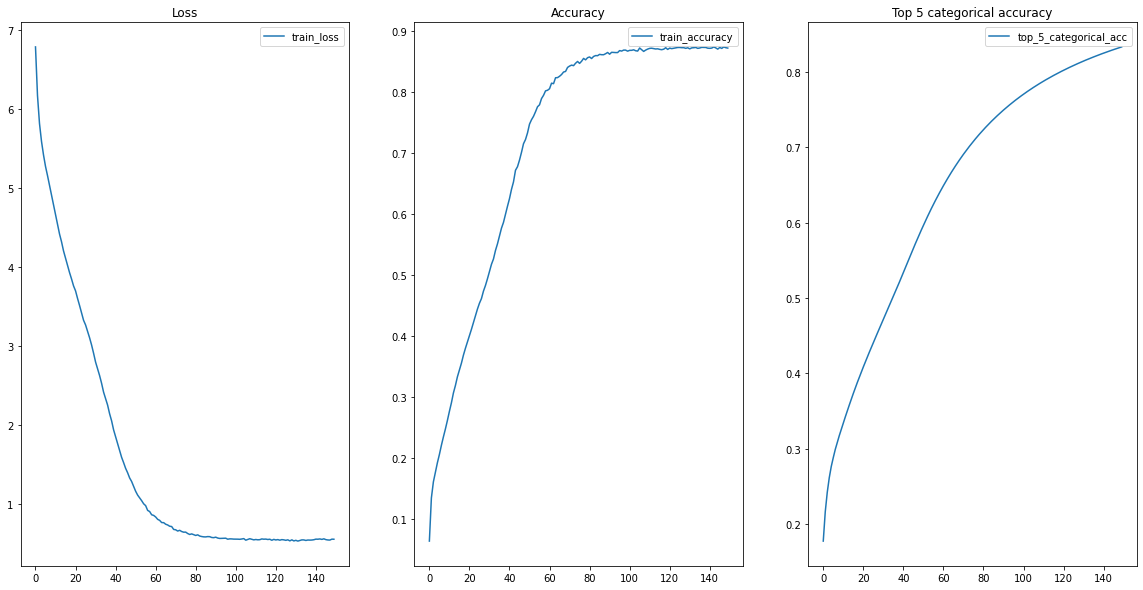

In [89]:
graph(results6)

There is no variance in the top k categorical accuracy measure. This model is giving over 80% accuracy if the target is in the top 5 predicted words. The loss has variance. 

## Model 7

Using 2 LSTM layers, with optimizer adam and making the Dense layer the output layer. 

In [83]:
model7 = Sequential()
model7.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model7.add(Dropout(0.2))
model7.add(LSTM(256))
model7.add(Dropout(0.2))
model7.add(Dense(y.shape[1], activation='softmax'))
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy", tf.keras.metrics.TopKCategoricalAccuracy(k=5)])

checkpoint7 = ModelCheckpoint("nextword7.h5", monitor='loss', verbose=1, save_best_only=True, mode='min')

# fit the model
results7=model7.fit(X, y, epochs=100, batch_size=64, callbacks=checkpoint7).history

Epoch 1/100
455/455 [==============================] - 7s 8ms/step - loss: 7.3961 - accuracy: 0.0447 - top_k_categorical_accuracy: 0.1520

Epoch 00001: loss improved from inf to 7.07225, saving model to nextword7.h5
Epoch 2/100
455/455 [==============================] - 4s 8ms/step - loss: 6.5132 - accuracy: 0.0698 - top_k_categorical_accuracy: 0.1754

Epoch 00002: loss improved from 7.07225 to 6.43715, saving model to nextword7.h5
Epoch 3/100
455/455 [==============================] - 4s 9ms/step - loss: 5.9555 - accuracy: 0.1476 - top_k_categorical_accuracy: 0.2028

Epoch 00003: loss improved from 6.43715 to 5.91305, saving model to nextword7.h5
Epoch 4/100
455/455 [==============================] - 4s 9ms/step - loss: 5.4166 - accuracy: 0.1937 - top_k_categorical_accuracy: 0.2322

Epoch 00004: loss improved from 5.91305 to 5.43620, saving model to nextword7.h5
Epoch 5/100
455/455 [==============================] - 4s 9ms/step - loss: 4.9531 - accuracy: 0.2299 - top_k_categorical_acc

In [126]:
scores.append(89.3)

In [137]:
accuracy.append(90.1)
loss.append(0.34)

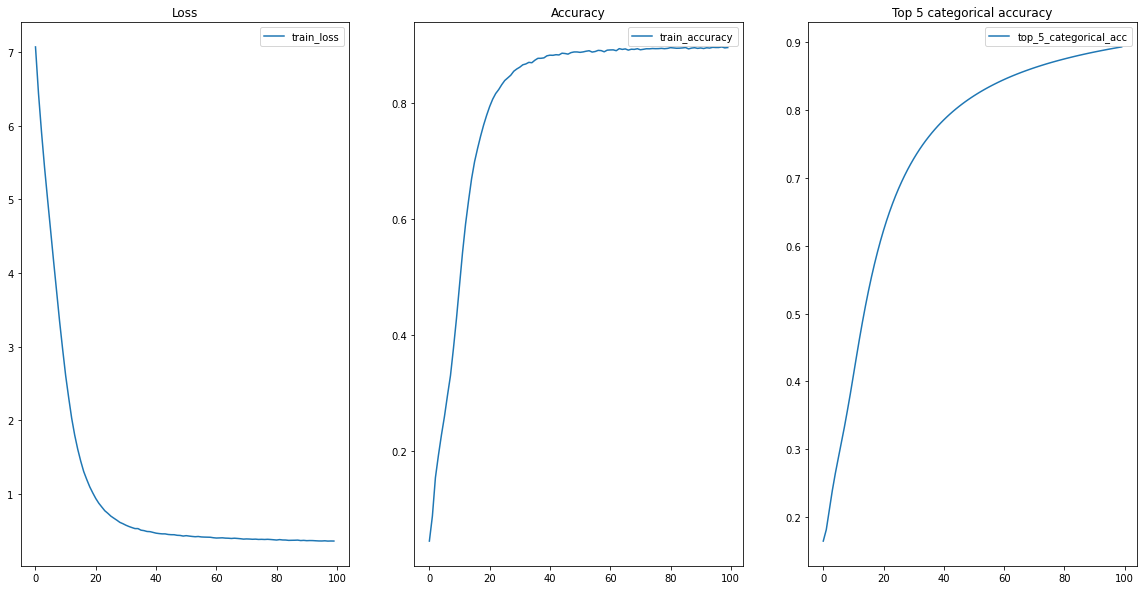

In [84]:
graph(results7)

There is a huge variance in the loss. The top k categorical accuracy is giving 80% results, with extremely small variance.

In [118]:
models = ["Modelfsm", "Model1", "Model2", "Model5", "Model6", "Model7"]


In [138]:
print(scores)
print(accuracy)
print(loss)

[51.2, 57.1, 68.5, 94.04, 83.3, 89.3]
[50.07, 21.66, 27.8, 90.7, 88.05, 90.1]
[4.82, 6.83, 6.27, 0.26, 0.51, 0.34]


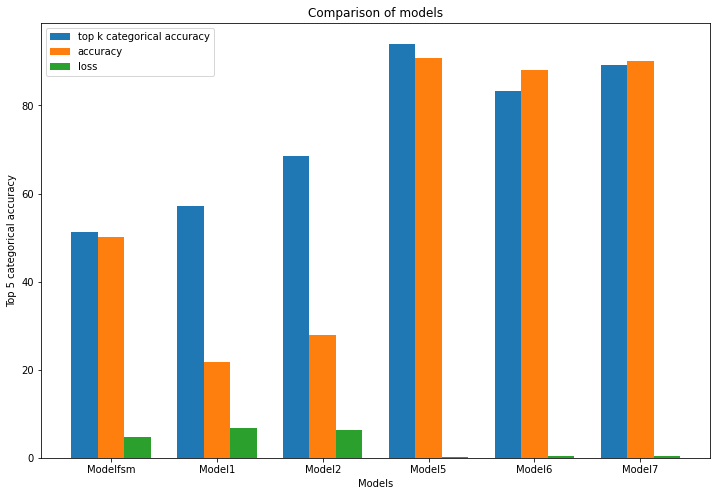

In [156]:
x = np.arange(6)
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x-0.25, scores, width = 0.25, label="top k categorical accuracy")
ax.bar(x, accuracy, width = 0.25, label="accuracy")
ax.bar(x+0.25, loss, width = 0.25, label="loss")
ax.set_title("Comparison of models")
ax.set_xlabel("Models")
plt.xticks(x, ["Modelfsm", "Model1", "Model2", "Model5", "Model6", "Model7"])
ax.set_ylabel("Top 5 categorical accuracy");
ax.legend()

# Predictions

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nextword5.h5 to nextword5 (1).h5


In [ ]:
model = load_model('nextword5.h5')

In [ ]:
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x
# prepare_input("کیلیفورنیا ریاستہائے متحدہ")

In [ ]:
import heapq
def sample(preds, top_n=5):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completions(model, text, n=5):
    if text == "":
        return("0")
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [unique_words[idx] for idx in next_indices]


In [ ]:
def predict(model):
  q =  input("ENTER TEXT: ")
  # print("correct sentence: ",q)
  seq =  q #" ".join(q)#tokenized.tokenize(q.lower())[0:3])
  print("Sequence: ",seq)
  print("next possible words: ", predict_completions(model, seq, 5))

Most of the models are giving the same words as predictions, in which 1-2 out of words are correct. Except the first simple model, model 5 and model 7, which is giving 3-4 out of 5 words correct.

The Final model to be used to make predictions is model5

In [ ]:
predict(model5)

ENTER TEXT: اور اس کے
Sequence:  اور اس کے
اور
اس
کے
next possible words:  ['لیے', 'علاوہ', 'مقام', 'میں', 'کے']


In [ ]:
predict(model5)

ENTER TEXT: ایران کا ایک
Sequence:  ایران کا ایک
ایران
کا
ایک
next possible words:  ['رہائشی', 'شہر', 'جو', 'اور', 'میں']


In [ ]:
predict(model5)

ENTER TEXT: گرمیوں میں وہاں
Sequence:  گرمیوں میں وہاں
گرمیوں
میں
وہاں
next possible words:  ['کا', 'کی', 'پر', 'ریاستہائے', 'میں']


In [ ]:
predict(model5)

ENTER TEXT: امریکا کا ایک
Sequence:  امریکا کا ایک
امریکا
کا
ایک
next possible words:  ['رہائشی', 'ہوائی', 'ٹاؤن', 'شہر', 'کاؤنٹی']


In [ ]:
predict(model5)

ENTER TEXT: یہ اس سے
Sequence:  یہ اس سے
یہ
اس
سے
next possible words:  ['ء', 'آ', 'آئر', 'آئرائی', 'آئرس']


In [ ]:
predict(model5)

ENTER TEXT: موجودگی کا پتہ
Sequence:  موجودگی کا پتہ
موجودگی
کا
پتہ
next possible words:  ['ٹاؤن', 'علاقہ', 'ء', 'آ', 'آئر']


In [ ]:
predict(model5)

ENTER TEXT: اس لیے ان
Sequence:  اس لیے ان
اس
لیے
ان
next possible words:  ['پر', 'کا', 'صوبہ', 'میں', 'کی']


In [ ]:
predict(model5)

ENTER TEXT: کے لیے استعمال
Sequence:  کے لیے استعمال
کے
لیے
استعمال
next possible words:  ['کیا', 'کی', 'ایک', 'ہے', 'میں']


### Sentence

In [ ]:
predict(model5)

ENTER TEXT: اس لیے ان
Sequence:  اس لیے ان
اس
لیے
ان
next possible words:  ['پر', 'سے', 'کا', 'افراد', 'کے']


In [ ]:
predict(model5)

ENTER TEXT: اس لیے افراد
Sequence:  اس لیے افراد
اس
لیے
افراد
next possible words:  ['ایک', 'تھی', 'پر', 'کا', 'کے']


In [ ]:
predict(model5)

ENTER TEXT: لیے افراد پر
Sequence:  لیے افراد پر
لیے
افراد
پر
next possible words:  ['پاکستان', 'کے', 'ء', 'آ', 'آئر']


In [ ]:
predict(model5)

ENTER TEXT:  افراد پر پاکستان
Sequence:   افراد پر پاکستان
افراد
پر
پاکستان
next possible words:  ['نے', 'کا', 'کے', 'سے', 'ہے']


In [ ]:
predict(model5)

ENTER TEXT: پر پاکستان کا
Sequence:  پر پاکستان کا
پر
پاکستان
کا
next possible words:  ['ایک', 'یہ', 'مطلب', 'گیا', 'تھا']


In [ ]:
predict(model5)

ENTER TEXT: پاکستان کا ایک
Sequence:  پاکستان کا ایک
پاکستان
کا
ایک
next possible words:  ['رہائشی', 'پاکستان', 'جو', 'مشہور', 'اور']


In [ ]:
predict(model5)

ENTER TEXT: کا ایک اور
Sequence:  کا ایک اور
کا
ایک
اور
next possible words:  ['دو', 'شہر', 'ایک', 'کسی', 'کے']


In [ ]:
predict(model5)

ENTER TEXT: ایک اور
Sequence:  ایک اور
ایک
اور
next possible words:  ['تھا', 'ہے', 'شہر', 'ء', 'آ']


### One word 

In [ ]:
predict(model5)

ENTER TEXT: میں
Sequence:  میں
میں
next possible words:  ['ایک', 'ان', 'کی', 'اور', 'ء']
